In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [90]:
train_data = pd.read_csv('data/sentiment_dataset_train.csv', index_col = None)
test_data = pd.read_csv('data/sentiment_dataset_test.csv')
train_data.head()

,id,review,rating
0,0,Arrived about 10pm and check in was painless. ...,4
1,1,I checked in at 4pm even tough room was not re...,2
2,2,"I chose this hotel, as it was in a good locati...",2
3,3,"Great location, super close to shops & a 10min...",4
4,4,I was in the Sir Adam Hotel to visit a friend....,3


In [91]:
print(train_data['rating'][30942:30950])
train_data.drop(index= 30944, inplace= True)
print(train_data['rating'][30942:30950])

30942                                                5
30943                                                5
30944    Tables not made up prior to guest seating. 2.
30945                                                5
30946                                                2
30947                                                3
30948                                                1
30949                                                2
Name: rating, dtype: object
30942    5
30943    5
30945    5
30946    2
30947    3
30948    1
30949    2
30950    2
Name: rating, dtype: object


In [92]:
print('Shape {} \nSize {}'.format(train_data.shape, train_data.size))
print(train_data['rating'][30942:30950])
train_data.reset_index(drop=True, inplace=True)

Shape (35004, 3) 
Size 105012
30942    5
30943    5
30945    5
30946    2
30947    3
30948    1
30949    2
30950    2
Name: rating, dtype: object


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35004 entries, 0 to 35003
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35004 non-null  int64 
 1   review  35004 non-null  object
 2   rating  35004 non-null  object
dtypes: int64(1), object(2)
memory usage: 820.5+ KB


In [6]:
#To check for NaN or missing values in the DataFrame
train_data.isnull().sum()

id        0
review    0
rating    0
dtype: int64

In [7]:
rating_group=train_data.groupby(['rating']).size()

In [8]:
score_cluster = pd.DataFrame(rating_group, columns = ['number_per_score'], index = None)
scores = [1,2,3,4,5]
score_cluster['scores'] = scores
score_cluster.head()

,number_per_score,scores
rating,,
1,7028,1
2,7031,2
3,6971,3
4,6997,4
5,6977,5


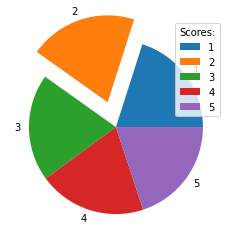

In [201]:
plt.pie(score_cluster['number_per_score'], labels=score_cluster['scores'], explode = [0, 0.3,0,0,0] )
plt.legend(title='Scores:')
plt.show()

<AxesSubplot:xlabel='scores', ylabel='number_per_score'>

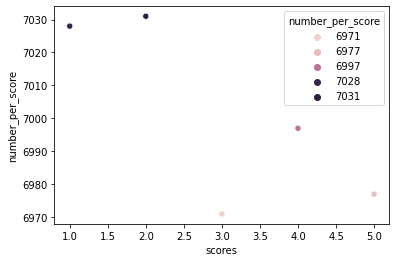

In [10]:
sns.scatterplot(data=score_cluster, x=score_cluster['scores'], y=score_cluster['number_per_score'],hue = score_cluster['number_per_score'] ,legend = 'full')

In [11]:
word_tokens = []
stemmer = PorterStemmer()
for i in range(0,len(train_data)):
    words = re.sub('[^a-zA-Z]',' ', train_data['review'][i])
    words =words.lower()
    words = words.split()
    words = [stemmer.stem(word) for word in words if not word in set(stopwords.words('english'))]
    words = ' '.join(words)
    word_tokens.append(words)

In [120]:
word_tokens[0]

'arriv pm check painless downsid hotel look citi centr locat mind walk want nois citi place ideal hotel bar restaur decent size gym roof terrac sun lounger room good size especi travel larg teenag good size loung doubl sofa bed kitchen area dine tabl main bedroom good size doubl wardrob safe shower room well size plenti towel good suppli toiletri hairdryer fridg come stock bottl water get start get hotel bar minut walk take marina metro station access'

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(max_features = 2000, ngram_range = (4,4))
x_train = countvec.fit_transform(word_tokens).toarray()
y_train = train_data['rating']

print(x_train.shape, y_train.shape)

(35004, 2000) (35004,)


In [122]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_train,y_train)



GaussianNB()

In [123]:
test_tokens = []
stemmer = PorterStemmer()
for i in range(0,len(test_data)):
    words = re.sub('[^a-zA-Z]',' ', test_data['review'][i])
    words =words.lower()
    words = words.split()
    words = [stemmer.stem(word) for word in words if not word in set(stopwords.words('english'))]
    words = ' '.join(words)
    test_tokens.append(words)

In [124]:
x_test = countvec.fit_transform(test_tokens).toarray()

In [125]:
predict_ratings = gaussian_nb.predict(x_test)
prob = gaussian_nb.predict_proba(x_test)

In [126]:
for i in range(5):
    print('Test review: {} \n\nprob_of_predicted_rating: {}\n' .format(test_data.review[i], prob[i]))

Test review: Not at all what expected.   Our mountain view was of the garage.  Asked to move but no rooms available and they said this was considered mountain view since it wasn't ocean view.   This was a business trip so if I was paying for this I would have been livid.  Would suggest if you book this place guarantee your view for the prices they charge.  No storage in bathroom at all.  Razor barely fit.  The three drawers provided were all this tiny and no space on the sink.    There coffee table is the size of a postage stamp so don't plan on putting anything there.  The rooms that they have for hotel guests are small.  Beware also the rooms have doorbells so kids and some guests like to ring these at all hours day and night.  We did complain so they had security do extra rounds.  Why a… 

prob_of_predicted_rating: [1. 0. 0. 0. 0.]

Test review: Good location as we needed to head to Reims the next day and the hotel is literally opposite the train station where we needed to catch the

In [127]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model1 = knn.fit(x_train,y_train)

In [128]:
knn_prediction = model1.predict(x_test)


In [202]:
predicted_prob_distr = model1.predict_proba(x_test)
for i in range(5):
    print('Test review: {} \n\nprob_of_predicted_rating KNN: {}\n' .format(test_data.review[i], predicted_prob_distr[i]))

Test review: Not at all what expected.   Our mountain view was of the garage.  Asked to move but no rooms available and they said this was considered mountain view since it wasn't ocean view.   This was a business trip so if I was paying for this I would have been livid.  Would suggest if you book this place guarantee your view for the prices they charge.  No storage in bathroom at all.  Razor barely fit.  The three drawers provided were all this tiny and no space on the sink.    There coffee table is the size of a postage stamp so don't plan on putting anything there.  The rooms that they have for hotel guests are small.  Beware also the rooms have doorbells so kids and some guests like to ring these at all hours day and night.  We did complain so they had security do extra rounds.  Why a… 

prob_of_predicted_rating KNN: [0.8 0.2 0.  0.  0. ]

Test review: Good location as we needed to head to Reims the next day and the hotel is literally opposite the train station where we needed to 

C:\Users\Vivek\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

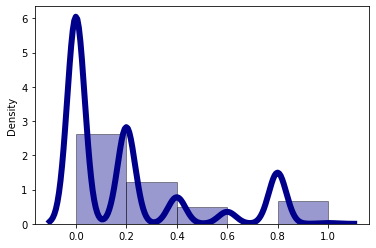

In [178]:
sns.distplot(predicted_prob_distr, hist=True, kde=True, 
             bins=int(25/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 6})

C:\Users\Vivek\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

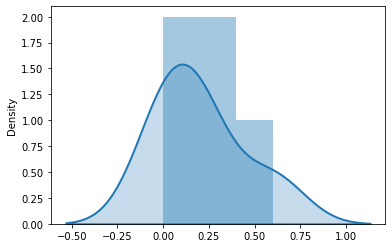

In [158]:
sns.distplot(prob[0:100], hist=True, kde=True,
             kde_kws={'shade': True, 'linewidth': 2})

In [204]:
def cos_similarity(x,y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))
print('Closeness score between 2 distributions showing max score at rating 1:' ,cos_similarity(prob[0],predicted_prob_distr[0]))


print('\nIndividual distributions confirming the same rating : \n NB {} \n KNN {}'.format(prob[0], predicted_prob_distr[0]))


Closeness score between 2 distributions showing max score at rating 1: [0.9701425  0.24253563 0.         0.         0.        ]

Individual distributions confirming the same rating : 
 NB 0.6 
 KNN [0.8 0.2 0.  0.  0. ]
